# CIFAR-10 Example with AlexNet

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

Here are the classes in the dataset, as well as 10 random images from each: 

<img src='https://drive.google.com/uc?id=1tsF12lE9IIW8BVFZgeEgMQIBG_nvWCXY' alt="CFIAR-10" width=500>

Key concepts illustrated

 * Structure of a deeper CNN

 * More pre-processing tools in `torchvision`

 * Chain layers together using `nn.Sequential`

 * Computation on GPU via CUDA semantics (`torch.device` and `to(device)`). In Colab environment, remember to select Runtime->Change runtime type->Hardware accelerator->GPU.

 * Examine the convolutional layers.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import transforms, datasets, models
from torchvision.utils import make_grid

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import seaborn as sns

## Load the internal data from `torchvision.datasets`

In [3]:
train_data = datasets.CIFAR10(root = '.data', train = True, download=True, transform = transforms.ToTensor())
test_data  = datasets.CIFAR10(root = '.data', train = False, download=True, transform = transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [4]:
print(train_data)
print(train_data.data.shape)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: .data
    Split: Train
    StandardTransform
Transform: ToTensor()
(50000, 32, 32, 3)


In [5]:
print(test_data)
print(test_data.data.shape)

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: .data
    Split: Test
    StandardTransform
Transform: ToTensor()
(10000, 32, 32, 3)


In [6]:
class_names = train_data.class_to_idx
print(class_names)
class_idx_to_names = dict([(j,i) for i,j in class_names.items()])
print(class_idx_to_names)

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


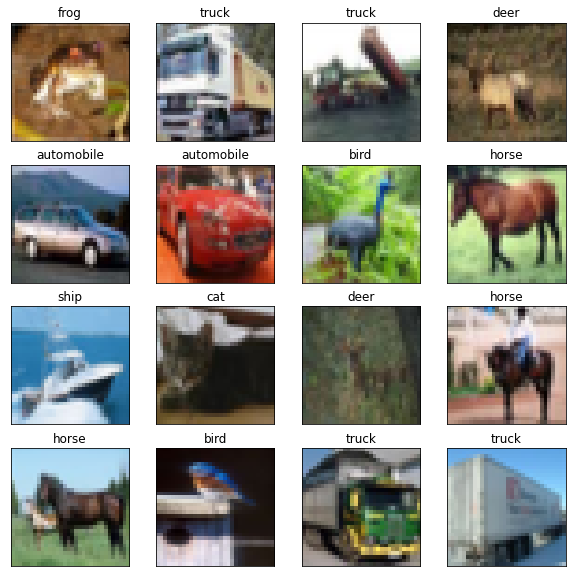

In [7]:
def img_plotter(img_list, lab_list):
    ncols = 4
    nrows = int(np.ceil(len(img_list)/ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2.5,nrows*2.5))
    for i in range(len(img_list)):
        image = img_list[i]
        label = lab_list[i]
        ax = axes.flat[i]
        if len(image.shape) == 3:
            ax.imshow(np.transpose(image.numpy(), (1, 2, 0)))
        else:
            ax.imshow(image.numpy())
        ax.set_title(label)
        ax.set_xticks([])
        ax.set_yticks([])

# View the first few images
count = 0
img_list = []
lab_list = []
for image, label in train_data:
    img_list.append(image)
    lab_list.append(class_idx_to_names[label])
    count += 1
    if count >= 16:
        break

img_plotter(img_list, lab_list)

## Pre-process the data

Since the images already have standardized sizes, this step will only do normalization and random changes.

In [8]:
# Find the mean and standard deviation of the training data
means = train_data.data.mean(axis=(0, 1, 2)) / 255
stds = train_data.data.std(axis=(0, 1, 2)) / 255

print(means)
print(stds)

[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]


In [9]:
# Re-load the data with transformations
# - transforms.RandomRotation: randomly rotate within (min,max) or +/-degrees range
# - transforms.RandomHorizontalFlip: randomly horizontal flip with given probability
# - transforms.RandomCrop: crop the image to given size, and optionally pad the edge of the image
train_transforms = transforms.Compose([
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(32, padding=2),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=means,
                                                std=stds)
                       ])
test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=means,
                                                std=stds)
                       ])


torch.manual_seed(999)

train_data = datasets.CIFAR10('./data', train=True, download=True,
                              transform=train_transforms)
test_data = datasets.CIFAR10('./data', train=False, download=True,
                             transform=test_transforms)

batch_size = 100
train_iterator = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_iterator = DataLoader(test_data, shuffle=False, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
for i,(img_list, lab_list) in enumerate(train_iterator):
  break

print(img_list.shape, img_list.dtype)
print(lab_list.shape, img_list.dtype)

torch.Size([100, 3, 32, 32]) torch.float32
torch.Size([100]) torch.float32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

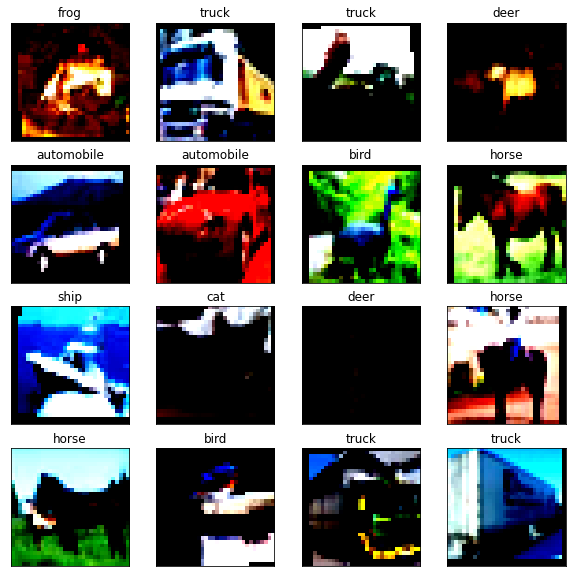

In [11]:
# RView the first few images after transformation
# Note the warnings occur because the normalization causes the values of image 
#   pixels to be out of the range of [0,1]. matplotlib expects the values of 
#   every pixel to be between [0,1], and clips out of range values. 
count = 0
img_list = []
lab_list = []
for image, label in train_data:
    img_list.append(image)
    lab_list.append(class_idx_to_names[label])
    count += 1
    if count >= 16:
        break

img_plotter(img_list, lab_list)

## Define the AlexNet Model

In [13]:
class AlexNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        self.features = nn.Sequential(
            # original image size: 32x32; after stride: 16x16
            nn.Conv2d(3, 32, 3, 2, 1),  # in_channels, out_channels, kernel_size, stride, padding
            # image size after first max-pooling: 8x8
            nn.MaxPool2d(2),  # kernel_size
            nn.ReLU(inplace=True), ## F.relu() is just a function, whereas nn.Relu is a module
            nn.Conv2d(32, 96, 3, padding=1), # padding size to avoid cropping
            # image size after second max-pooling: 4x4
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 192, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            # image size after third max-pooling: 2x2
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128 * 2 * 2, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(2048, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x.view(-1, 128 * 2 * 2))
        return F.log_softmax(x, dim=1)

## Instantiate the model, define loss and optimization functions

In [14]:
model = AlexNet(len(class_names))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
num_epochs = 100

def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

   864
    32
 27648
    96
165888
   192
221184
   128
147456
   128
1048576
  2048
4194304
  2048
 20480
    10
______
5831082


## Train the Model

In deep neural networks, initialization matters to model performance. Initializing all the parameters to zero (or other constant numbers) will make the neurons all learn the same features during training. Also, when the parameters are too small or too large, the model will have vanishing or exploding gradients. Therefore, the common practice is to initialize the model parameters to small random numbers, in inverse proportion to the number of parameters.

Common formal methods: Xavier initialization, Kaiming initialization.

In [15]:
def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

model.apply(initialize_parameters)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(192, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=512, out_features=2048, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inpla

Demonstrates training time on CPU using one epoch

In [16]:
def train_model(num_epochs, model, train_iterator, optimizer, criterion, device):
    start_time = time.time()

    train_epochs = num_epochs
    train_losses = []

    model.to(device) # attach model to device
    criterion.to(device) # attach loss function to device

    for i in range(train_epochs):
        for j, (img_list, lab_list) in enumerate(train_iterator):

            img_list = img_list.to(device) # attach training data to device
            lab_list = lab_list.to(device) # attach training data to device

            lab_pred = model(img_list)
            loss = criterion(lab_pred, lab_list)

            if j%200 == 0:
                print(f'epoch: {i:2}  batch: {j:4} [{batch_size*j:6}/50000]  loss: {loss.item():10.8f}')

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_losses.append(loss)

    print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

    return train_losses

In [15]:
device = torch.device('cpu')
train_model(1, model, train_iterator, optimizer, criterion, device)

epoch:  0  batch:    0 [     0/50000]  loss: 5.08523750
epoch:  0  batch:  200 [ 20000/50000]  loss: 1.71054780
epoch:  0  batch:  400 [ 40000/50000]  loss: 1.64855719

Duration: 124 seconds


[tensor(1.6421, grad_fn=<NllLossBackward0>)]

Demonstrates training time on GPU using one epoch

In [17]:
model.apply(initialize_parameters)
optimizer.zero_grad()

device = torch.device('cuda')
train_model(1, model, train_iterator, optimizer, criterion, device)

epoch:  0  batch:    0 [     0/50000]  loss: 6.88887596
epoch:  0  batch:  200 [ 20000/50000]  loss: 1.67448926
epoch:  0  batch:  400 [ 40000/50000]  loss: 1.66512585

Duration: 25 seconds


[tensor(1.5474, device='cuda:0', grad_fn=<NllLossBackward0>)]

Actual training

In [18]:
train_losses = train_model(num_epochs, model, train_iterator, optimizer, criterion, device)

epoch:  0  batch:    0 [     0/50000]  loss: 1.49971533
epoch:  0  batch:  200 [ 20000/50000]  loss: 1.27773583
epoch:  0  batch:  400 [ 40000/50000]  loss: 1.49050736
epoch:  1  batch:    0 [     0/50000]  loss: 1.45791996
epoch:  1  batch:  200 [ 20000/50000]  loss: 1.12161458
epoch:  1  batch:  400 [ 40000/50000]  loss: 1.13127184
epoch:  2  batch:    0 [     0/50000]  loss: 1.14905930
epoch:  2  batch:  200 [ 20000/50000]  loss: 1.36037445
epoch:  2  batch:  400 [ 40000/50000]  loss: 1.21446848
epoch:  3  batch:    0 [     0/50000]  loss: 1.08779728
epoch:  3  batch:  200 [ 20000/50000]  loss: 1.08059609
epoch:  3  batch:  400 [ 40000/50000]  loss: 1.10245275
epoch:  4  batch:    0 [     0/50000]  loss: 0.87138575
epoch:  4  batch:  200 [ 20000/50000]  loss: 1.12441361
epoch:  4  batch:  400 [ 40000/50000]  loss: 1.08794022
epoch:  5  batch:    0 [     0/50000]  loss: 1.21194434
epoch:  5  batch:  200 [ 20000/50000]  loss: 0.98309183
epoch:  5  batch:  400 [ 40000/50000]  loss: 1.0

Plot loss functions

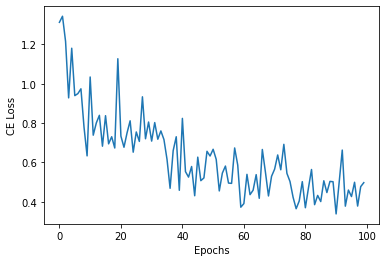

In [19]:
if num_epochs == len(train_losses):
    plt.plot(torch.Tensor(train_losses).detach().numpy())
    plt.xlabel('Epochs')
    plt.ylabel('CE Loss')
else:
    raise 'Training is not finished.'

In [20]:
# save the trained model
torch.save(model.state_dict(), 'AlexNet_CIFAR-10.pt')

## Evaluate the model

In [21]:
model2 = AlexNet(10)
model2.load_state_dict(torch.load('AlexNet_CIFAR-10.pt'))

def calc_accuracy(y_pred, y):
    which = y_pred.argmax(1)
    correct = (which == y).float().mean() * 100
    return correct

start_time = time.time()

test_losses = []
test_accuracy = []

model2.eval()

with torch.no_grad():
    for j, (img_list, lab_list) in enumerate(test_iterator):
        lab_pred = model2(img_list)

        loss = criterion(lab_pred, lab_list)
        test_losses.append(loss)

        acc = calc_accuracy(lab_pred, lab_list)
        test_accuracy.append(acc)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed


Duration: 8 seconds


Text(0, 0.5, 'CE Loss')

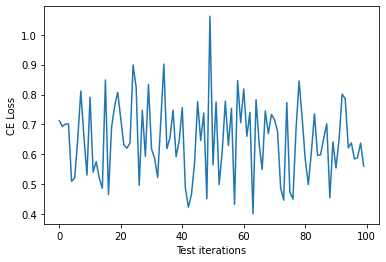

In [22]:
plt.plot(torch.Tensor(test_losses).detach().numpy())
plt.xlabel('Test iterations')
plt.ylabel('CE Loss')

Text(0, 0.5, 'Correct classifications (%)')

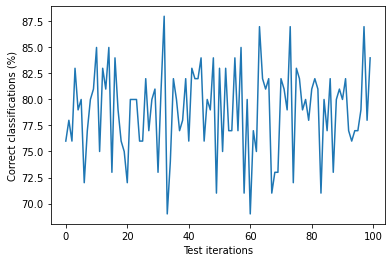

In [24]:
plt.plot(torch.Tensor(test_accuracy).detach().numpy())
plt.xlabel('Test iterations')
plt.ylabel('Correct classifications (%)')

Make the confusion matrix using all of the test data

In [31]:
# Create a loader for the entire the test set
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    for X_test, y_test in test_load_all:
        test_pred_all = model(X_test.to(device))
        correct = (test_pred_all.argmax(1) == y_test.to(device))

test_pred_all = test_pred_all.cpu().detach().numpy()
correct = correct.cpu().detach().numpy()

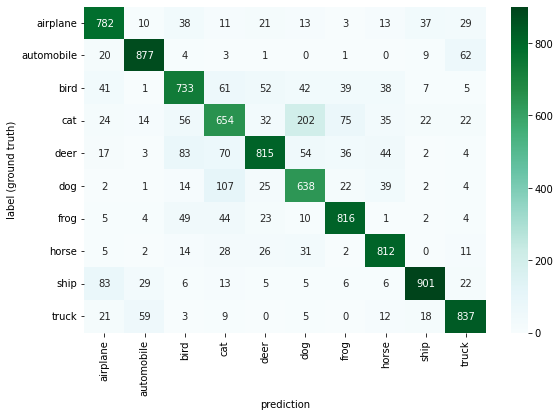

In [32]:
arr = confusion_matrix(test_pred_all.argmax(1), y_test.detach().numpy())

df_cm = pd.DataFrame(arr, [class_idx_to_names[i] for i in range(10)], [class_idx_to_names[i] for i in range(10)])
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()


## Examine the top misses

Top misses are defined as the instances that are missclassified but have high confidence in the classified result.

In [35]:
test_class_all  = test_pred_all.argmax(1).astype(int)
test_class_true = y_test.detach().numpy()
test_probs_all  = np.exp(np.max(test_pred_all, axis = 1))
top_misses      = np.argsort(test_probs_all * (1 - correct))[::-1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

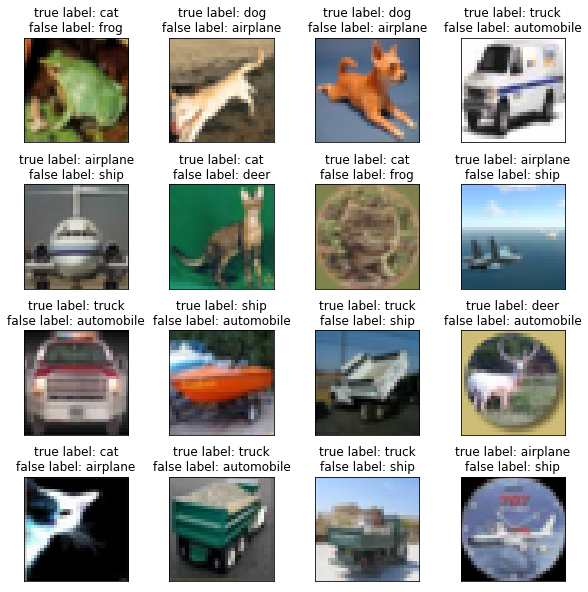

In [36]:
img_list = []
lab_list = []
for i in range(16):
    j = top_misses[i]
    img_list.append( (X_test[j] * stds.reshape(3,1,1) + means.reshape(3,1,1))  ) # re-normalize
    lab_list.append( f'true label: {class_idx_to_names[test_class_true[j]]}\nfalse label: {class_idx_to_names[test_class_all[j]]}' )
img_plotter(img_list, lab_list)
plt.subplots_adjust(hspace=0.4)

## Examine the trained filters

In [37]:
model.features # sequence of modules

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU(inplace=True)
  (3): Conv2d(32, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): ReLU(inplace=True)
  (6): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(192, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): ReLU(inplace=True)
)

In [38]:
filters = model.features[0].weight.data

In [39]:
filters.shape

torch.Size([32, 3, 3, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

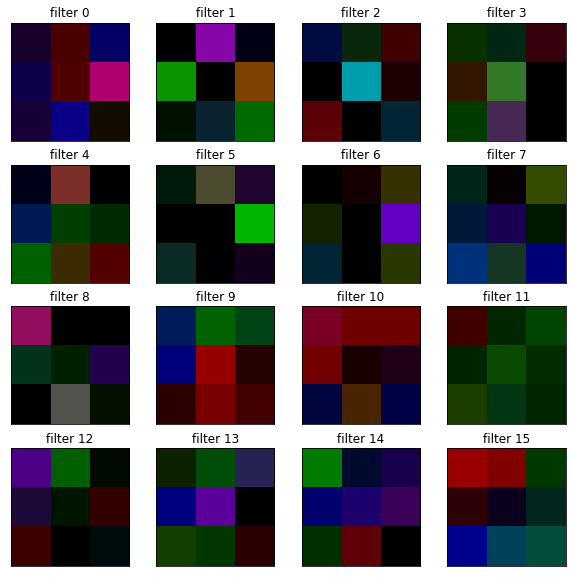

In [42]:
img_list = []
lab_list = []
for i in range(16):
    img_list.append( filters[i].cpu().detach() )
    lab_list.append( f'filter {i}' )
img_plotter(img_list, lab_list)

## Examine the filtered images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


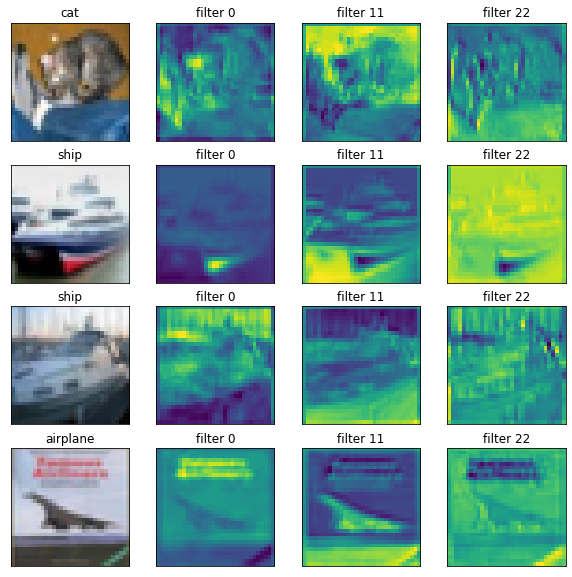

In [48]:
img_list = []
lab_list = []
for i in range(4):
    img_list.append( X_test[i] * stds.reshape(-1,1,1) + means.reshape(-1,1,1) )
    lab_list.append( class_idx_to_names[test_class_true[i]] )
    for j in range(0,32,11):
        img_list.append( F.conv2d(X_test[i].unsqueeze(0), filters[j].cpu().unsqueeze(0), padding = 1).detach()[0,0,:,:] )
        lab_list.append( f'filter {j}' )
img_plotter(img_list, lab_list)